In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
# Regressor is used instead of classifier since target is continuous
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error, r2_score
import xgboost as xgb 
%matplotlib inline

## Data preparation

In [3]:
df = pd.read_csv('../datasets/car-fuel.csv')

categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
numerical_columns = [col for col in df.columns if df[col].dtype != 'object' and col != 'converted']

df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,0.0,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,0.0,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


# Split the dataset

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

Use DictVectorizer to turn the dictionaries into numerical feature matrix

In [5]:
# Initialize the vectorizer
dv = DictVectorizer(sparse=True) # Stores only the non-zero elements and their coordinates.

# Convert dataframe to list of dictionaries
train_dicts = df_train.to_dict(orient='records') 
val_dicts = df_val.to_dict(orient='records')

In [6]:
train_dicts[:3]

[{'engine_displacement': 120,
  'num_cylinders': 5.0,
  'horsepower': 169.0,
  'vehicle_weight': 2966.67950463456,
  'acceleration': 13.9,
  'model_year': 2005,
  'origin': 'USA',
  'fuel_type': 'Gasoline',
  'drivetrain': 'Front-wheel drive',
  'num_doors': -1.0},
 {'engine_displacement': 200,
  'num_cylinders': 3.0,
  'horsepower': 143.0,
  'vehicle_weight': 2950.822121334588,
  'acceleration': 17.1,
  'model_year': 2013,
  'origin': 'Asia',
  'fuel_type': 'Diesel',
  'drivetrain': 'Front-wheel drive',
  'num_doors': -1.0},
 {'engine_displacement': 180,
  'num_cylinders': 6.0,
  'horsepower': 180.0,
  'vehicle_weight': 3078.221669239548,
  'acceleration': 17.4,
  'model_year': 2007,
  'origin': 'USA',
  'fuel_type': 'Gasoline',
  'drivetrain': 'All-wheel drive',
  'num_doors': 0.0}]

In [7]:
# Fit and transform the training data into numerical feature matrix
X_train = dv.fit_transform(train_dicts) 
X_val = dv.transform(val_dicts)
X_train[:3]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30 stored elements and shape (3, 14)>

# Train Decision tree model with max depth 1

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
# Validate on validation set
y_pred = dt.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'RMSE: {rmse:.3f}, R2: {r2:.3f}')
# # Print the learned tree rules
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

RMSE: 1.610, R2: 0.614
|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Train Decision tree model with max depth 3

In [9]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_train)
# Validate on validation set
y_pred = dt.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'RMSE: {rmse:.3f}, R2: {r2:.3f}')
# # Print the learned tree rules
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

RMSE: 0.710, R2: 0.925
|--- vehicle_weight <= 3022.11
|   |--- vehicle_weight <= 2505.96
|   |   |--- vehicle_weight <= 2069.91
|   |   |   |--- value: [20.77]
|   |   |--- vehicle_weight >  2069.91
|   |   |   |--- value: [18.37]
|   |--- vehicle_weight >  2505.96
|   |   |--- vehicle_weight <= 2750.89
|   |   |   |--- value: [16.83]
|   |   |--- vehicle_weight >  2750.89
|   |   |   |--- value: [15.56]
|--- vehicle_weight >  3022.11
|   |--- vehicle_weight <= 3506.12
|   |   |--- vehicle_weight <= 3268.69
|   |   |   |--- value: [14.26]
|   |   |--- vehicle_weight >  3268.69
|   |   |   |--- value: [13.12]
|   |--- vehicle_weight >  3506.12
|   |   |--- vehicle_weight <= 3848.64
|   |   |   |--- value: [11.71]
|   |   |--- vehicle_weight >  3848.64
|   |   |   |--- value: [9.67]



## Train RandomForestClassifier 

In [10]:
rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'RMSE: {rmse:.3f}, R2: {r2:.3f}')

RMSE: 0.460, R2: 0.969


# Tune n_estimators parameter

In [11]:
rmse_scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n,
                            random_state=1,
                            n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append((n, rmse))
df_rmse1 = pd.DataFrame(rmse_scores, columns=['n_estimators', 'rmse'])
df_rmse1

,n_estimators,rmse
0,10,0.459578
1,20,0.453591
2,30,0.451687
3,40,0.448721
4,50,0.446657
5,60,0.445460
6,70,0.445126
7,80,0.444984
8,90,0.444861
9,100,0.444652


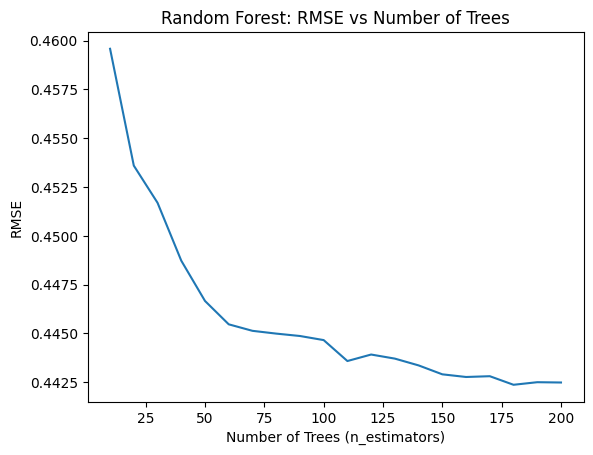

In [12]:
plt.plot(df_rmse1['n_estimators'], df_rmse1['rmse'])
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest: RMSE vs Number of Trees')
plt.show()  

# Tune max_depth parameter

In [13]:
depth = [10, 15, 20, 25]
for d in depth:
   for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                max_depth=d,
                                n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append((n, d, rmse))
        
df_rmse2 = pd.DataFrame(rmse_scores, columns=['n_estimators', 'max_depth', 'rmse'])
df_rmse2

,n_estimators,max_depth,rmse
0,10,0.459578,NaN
1,20,0.453591,NaN
2,30,0.451687,NaN
3,40,0.448721,NaN
4,50,0.446657,NaN
...,...,...,...
95,160,25.000000,0.442800
96,170,25.000000,0.442843
97,180,25.000000,0.442409
98,190,25.000000,0.442534


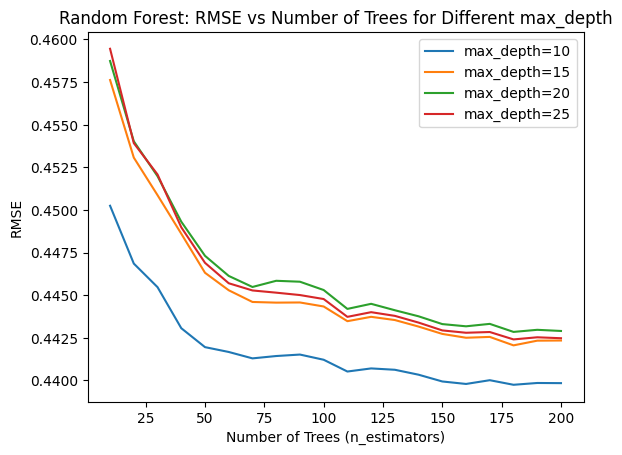

In [14]:
# Plot rmse vs n_estimators for different max_depth values
for d in depth:
    df_subset = df_rmse2[df_rmse2['max_depth'] == d]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label=f'max_depth={d}')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('Random Forest: RMSE vs Number of Trees for Different max_depth')
plt.legend()

Best max_depth is 10

# Training Random Forest model 
Parameters n_estimators=10, max_depth=20, random_state=1,n_jobs=-1  
Find the feature importance

In [15]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
importance_values = rf.feature_importances_
feature_names = dv.get_feature_names_out()
feature_importance_df = pd.DataFrame(
        {'feature': feature_names,
         'importance': importance_values}
    )
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df

,feature,importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635
12,origin=USA,0.000540
11,origin=Europe,0.000519
10,origin=Asia,0.000462


# Train XGBoost model

In [16]:
features = list(dv.get_feature_names_out())
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [17]:
%%capture output1
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model1 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [18]:
y_pred = model1.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.450


In [19]:
print(output1.stdout)

[0]	train-rmse:1.81393	val-rmse:1.85444
[5]	train-rmse:0.51381	val-rmse:0.55664
[10]	train-rmse:0.37115	val-rmse:0.43896
[15]	train-rmse:0.34666	val-rmse:0.43362
[20]	train-rmse:0.33553	val-rmse:0.43376
[25]	train-rmse:0.32268	val-rmse:0.43683
[30]	train-rmse:0.31475	val-rmse:0.43752
[35]	train-rmse:0.30960	val-rmse:0.43784
[40]	train-rmse:0.30202	val-rmse:0.43968
[45]	train-rmse:0.29126	val-rmse:0.44024
[50]	train-rmse:0.28456	val-rmse:0.44140
[55]	train-rmse:0.27618	val-rmse:0.44225
[60]	train-rmse:0.26768	val-rmse:0.44290
[65]	train-rmse:0.26174	val-rmse:0.44352
[70]	train-rmse:0.25489	val-rmse:0.44531
[75]	train-rmse:0.24792	val-rmse:0.44628
[80]	train-rmse:0.24254	val-rmse:0.44689
[85]	train-rmse:0.23644	val-rmse:0.44749
[90]	train-rmse:0.23193	val-rmse:0.44839
[95]	train-rmse:0.22475	val-rmse:0.44904
[99]	train-rmse:0.21950	val-rmse:0.45018



In [20]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [21]:
df_score1 = parse_xgb_output(output1)

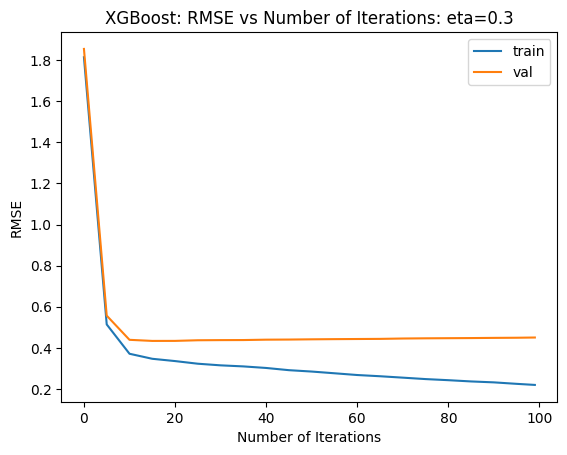

In [22]:
plt.plot(df_score1.num_iter, df_score1.train_rmse, label='train')
plt.plot(df_score1.num_iter, df_score1.val_rmse, label='val')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost: RMSE vs Number of Iterations: eta=0.3')
plt.legend()

# Tune XGBoost 
Use eta parameter as 0.1

In [23]:
%%capture output2
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model2 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [24]:
y_pred = model2.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.426


In [25]:
print(output2.stdout)

[0]	train-rmse:2.28944	val-rmse:2.34561
[5]	train-rmse:1.41247	val-rmse:1.44988
[10]	train-rmse:0.91008	val-rmse:0.94062
[15]	train-rmse:0.63402	val-rmse:0.66672
[20]	train-rmse:0.48983	val-rmse:0.53064
[25]	train-rmse:0.41881	val-rmse:0.46891
[30]	train-rmse:0.38342	val-rmse:0.44289
[35]	train-rmse:0.36435	val-rmse:0.43250
[40]	train-rmse:0.35343	val-rmse:0.42746
[45]	train-rmse:0.34621	val-rmse:0.42595
[50]	train-rmse:0.33998	val-rmse:0.42498
[55]	train-rmse:0.33480	val-rmse:0.42449
[60]	train-rmse:0.33054	val-rmse:0.42456
[65]	train-rmse:0.32602	val-rmse:0.42493
[70]	train-rmse:0.32202	val-rmse:0.42503
[75]	train-rmse:0.31895	val-rmse:0.42526
[80]	train-rmse:0.31667	val-rmse:0.42563
[85]	train-rmse:0.31440	val-rmse:0.42574
[90]	train-rmse:0.31059	val-rmse:0.42586
[95]	train-rmse:0.30625	val-rmse:0.42611
[99]	train-rmse:0.30419	val-rmse:0.42623



In [26]:
df_score2 = parse_xgb_output(output2)

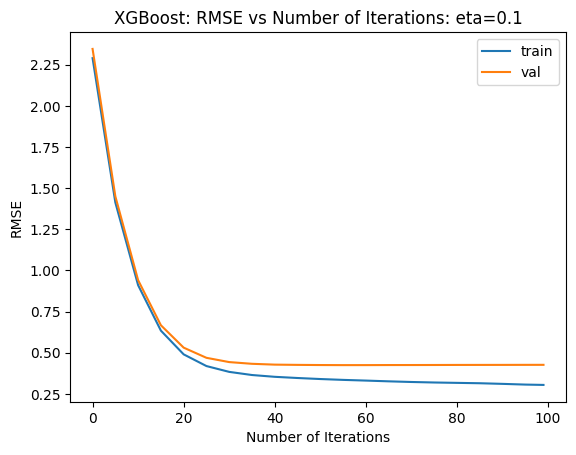

In [27]:
plt.plot(df_score2.num_iter, df_score2.train_rmse, label='train')
plt.plot(df_score2.num_iter, df_score2.val_rmse, label='val')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost: RMSE vs Number of Iterations: eta=0.1')
plt.legend()

# Choose the best model

In [28]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_train)
# Validate on validation set
y_pred = dt.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.710


In [29]:
rf = RandomForestRegressor(n_estimators=110,
                            random_state=1,
                            max_depth=10,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)

print(f'RMSE: {rmse:.3f}')

RMSE: 0.441


In [30]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = xgb_model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.426


RMSE score for XGB model is lesser than randomforest and decisiontree model. Hence train full dataset using XGB model

In [31]:
y_full_train = df_full_train['fuel_efficiency_mpg'].values
del df_full_train['fuel_efficiency_mpg']


In [32]:
# Convert DataFrames to dicts
dicts_full_train = df_full_train.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

dv_final = DictVectorizer(sparse=True)
X_full_train = dv_final.fit_transform(dicts_full_train)
X_test = dv_final.transform(dicts_test)

In [33]:
# Get feature names
features = dv_final.get_feature_names_out()
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=list(features))

dtest = xgb.DMatrix(X_test, feature_names=list(features))

In [34]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)
y_pred = xgb_model.predict(dtest)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.3f}')

RMSE: 0.415
